# An Introduction to SageMaker Object2Vec model for MovieLens recommendations


1. [Background](#Background)
1. [Data exploration and preparation](#Data-exploration-and-preparation)
1. [Rating prediction task](#Rating-prediction-task)
1. [Recommendation task](#Recommendation-task)

# Background

### Object2Vec
*Object2Vec* is a highly customizable multi-purpose algorithm that can learn embeddings of pairs of objects. The embeddings are learned such that it preserves their pairwise **similarities** in the original space.
- **Similarity** is user-defined: users need to provide the algorithm with pairs of objects that they define as similar (1) or dissimilar (0); alternatively, the users can define similarity in a continuous sense (provide a real-valued similarity score)
- The learned embeddings can be used to efficiently compute nearest neighbors of objects, as well as to visualize natural clusters of related objects in the embedding space. In addition, the embeddings can also be used as features of the corresponding objects in downstream supervised tasks such as classification or regression

## In this notebook example:
We demonstrate how Object2Vec can be used to solve problems arising in recommendation systems. Specifically,

- We provide the algorithm with (UserID, MovieID) pairs; for each such pair, we also provide a "label" that tells the algorithm whether the user and movie are similar or not

     * When the labels are real-valued, we use the algorithm to predict the exact ratings of a movie given a user
     * When the labels are binary, we use the algorithm to recommendation movies to users

- The diagram below shows the customization of our model to the problem of predicting movie ratings, using a dataset that provides `(UserID, ItemID, Rating)` samples. Here, ratings are real-valued

<img style="float:middle" src="images/image_ml_rating.png" width="480">

### Dataset
We use the MovieLens 100k dataset: https://grouplens.org/datasets/movielens/100k/

#### License
Please be aware of the following requirements about ackonwledgment, copyright and availability, cited from the [data set description page](http://files.grouplens.org/datasets/movielens/ml-100k-README.txt).
>The data set may be used for any research
purposes under the following conditions:
     * The user may not state or imply any endorsement from the
       University of Minnesota or the GroupLens Research Group.
     * The user must acknowledge the use of the data set in
       publications resulting from the use of the data set
       (see below for citation information).
     * The user may not redistribute the data without separate
       permission.
     * The user may not use this information for any commercial or
       revenue-bearing purposes without first obtaining permission
       from a faculty member of the GroupLens Research Project at the
       University of Minnesota.
If you have any further questions or comments, please contact GroupLens \<grouplens-info@cs.umn.edu\>. 

### Use cases

- Task 1: Rating prediction (regression)
- Task 2: Movie recommendation (classification)
- Task 3: Nearest-neighbor movie retrieval in the learned embedding space (will do this in a Lambda function)

### Before running the notebook
- Please use a Python 3 kernel for the notebook (e.g. conda_python3).
- Go to S3 and make a note of the name of the bucket you created for this Lab.
- Please make sure you have `jsonlines` package installed (if not, you can run the command below to install it).

In [26]:
bucket = 'md-labs-ml-bucket' # Replace with your own bucket name

In [27]:
# !pip install jsonlines

In [28]:
import sys
! echo {sys.prefix}
! {sys.prefix}/bin/pip install jsonlines

/home/ec2-user/anaconda3/envs/python3


Start by importing the libraries needed to complete the Lab. Please note that customutil is a custom library included with this notebook. It provides utility methods for loading data, transforming data, and writing data. Take a look at the methods in `customutil.py`.

In [29]:
import os
import sys
import csv, jsonlines
import numpy as np
import copy
import random
import customutil as cu

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt

# Data exploration and preparation
Start by downloading the dataset and unzipping it.

In [31]:
%%bash

curl -o ml-100k.zip http://files.grouplens.org/datasets/movielens/ml-100k.zip
unzip ml-100k.zip
rm ml-100k.zip

Archive:  ml-100k.zip
  inflating: k.zip                   


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4808k  100 4808k    0     0   350k      0  0:00:13  0:00:13 --:--:--  311k
replace ml-100k/allbut.pl? [y]es, [n]o, [A]ll, [N]one, [r]ename: new name: replace ml-100k/mku.sh? [y]es, [n]o, [A]ll, [N]one, [r]ename:  NULL
(EOF or read error, treating as "[N]one" ...)


We want to explore the data from two angles - from a per-user perspective and from a per-movie perspective. To achieve this, use the custom utility methods to:
- Load the data from the CSV file
- Shuffle the data
- Re-format the data into a per-user set and a per-movie set

In [32]:
# Set the data paths
prefix = 'ml-100k'
train_path = os.path.join(prefix, 'ua.base')
valid_path = os.path.join(prefix, 'ua.test')

# Load data and shuffle
train_data_list = cu.load_csv_data(train_path, '\t')
random.shuffle(train_data_list)
validation_data_list = cu.load_csv_data(valid_path, '\t')
random.shuffle(validation_data_list)

In file ml-100k/ua.base, there are 90570 ratings
The ratings have mean: 3.52, median: 4.0, and variance: 1.27
There are 943 unique users and 1680 unique movies
In file ml-100k/ua.test, there are 9430 ratings
The ratings have mean: 3.59, median: 4.0, and variance: 1.25
There are 943 unique users and 1129 unique movies


In [33]:
# Create a per-user dataset and a per-movie dataset
to_users_dict, to_movies_dict = cu.csv_to_augmented_data_dict(train_path, '\t')

### We perform some data exploration
To gain a better understanding of the data we are working with, do some basic data exploration in three steps:
1. Calculate some basic stats such as minimum, maximum, and mean to understand how many movies are watched per user, and to understand how many users watch a movie.
2. Check if there are users who have watched very few movies, or movies which have been watched by very few users. It could be wise to remove these from the dataset.
3. Plot some graphs to visually explore the data.

In [34]:
# Calculate min, max, median of number of movies per user
movies_per_user = [len(val) for key, val in to_users_dict.items()]
print("The min, max, and median 'movies per user' is {}, {}, and {}".format(np.amin(movies_per_user),
                                                                        np.amax(movies_per_user),
                                                                         np.median(movies_per_user)))

The min, max, and median 'movies per user' is 10, 727, and 55.0


In [35]:
# Calculate min, max, median of number of users per movie
users_per_movie = [len(val) for key, val in to_movies_dict.items()]
print("The min, max, and median 'users per movie' is {}, {}, and {}".format(np.amin(users_per_movie),
                                                                         np.amax(users_per_movie),
                                                                          np.median(users_per_movie)))

The min, max, and median 'users per movie' is 1, 495, and 25.0


In [36]:
# Calculate how many users have watched less than a certain number of movies
count = 0
n_movies_lower_bound = 20
for n_movies in movies_per_user:
    if n_movies <= n_movies_lower_bound:
        count += 1
print("In the training set")
print('There are {} users with no more than {} movies'.format(count, n_movies_lower_bound))

In the training set
There are 213 users with no more than 20 movies


In [37]:
# Calculate how many movies have been watched by less than a certain threshold of users
count = 0
n_users_lower_bound = 2
for n_users in users_per_movie:
    if n_users <= n_users_lower_bound:
        count += 1
print('There are {} movies with no more than {} user'.format(count, n_users_lower_bound))

There are 12 movies with no more than 2 user


Text(0.5, 1.0, 'Movies per user')

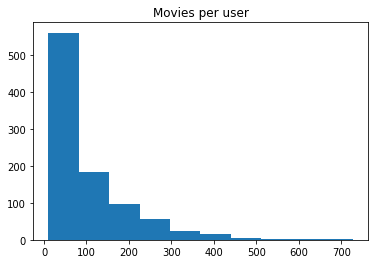

In [38]:
# Generate histogram for the number of movies watched per user 
f = plt.figure(1)
plt.hist(movies_per_user)
plt.title("Movies per user")

Text(0.5, 1.0, 'Users per movie')

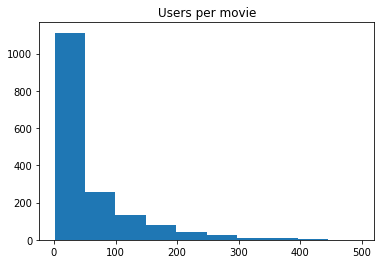

In [39]:
# Generate histogram for the number of users who watched a movie
g = plt.figure(2)
plt.hist(users_per_movie)
plt.title("Users per movie")

Since the number of movies with an extremely small number of users (<3) is negligible compared to the total number of movies, we will not remove movies from the data set (same applies for users).

# Rating prediction task 
In the rating prediction task, the model will predict the rating that a user will give to a movie.

In [40]:
# Save training and validation data locally for rating-prediction (regression) task.
cu.write_data_list_to_jsonl(copy.deepcopy(train_data_list), 'train_r.jsonl')
cu.write_data_list_to_jsonl(copy.deepcopy(validation_data_list), 'validation_r.jsonl')

# Format the validation data for testing in the inference step later.
valid_r_data, valid_r_label = cu.data_list_to_inference_format(copy.deepcopy(validation_data_list), binarize=False)

Created train_r.jsonl jsonline file
Created validation_r.jsonl jsonline file


In [41]:
# Define a function to evaluate the performance.
def get_mse_loss(res, labels):
    if type(res) is dict:
        res = res['predictions']
    assert len(res)==len(labels), 'result and label length mismatch!'
    loss = 0
    for row, label in zip(res, labels):
        if type(row)is dict:
            loss += (row['scores'][0]-label)**2
        else:
            loss += (row-label)**2
    return round(loss/float(len(labels)), 2)

#### We first test the problem on two baseline algorithms.

## Baseline 1

A naive approach to predict movie ratings on unseen data is to use the global average of the user predictions in the training data

In [42]:
train_r_label = [row['label'] for row in copy.deepcopy(train_data_list)]

bs1_prediction = round(np.mean(train_r_label), 2)
print('The Baseline 1 (global rating average) prediction is {}'.format(bs1_prediction))
print("The validation mse loss of the Baseline 1 is {}".format(
                                     get_mse_loss(len(valid_r_label)*[bs1_prediction], valid_r_label)))

The Baseline 1 (global rating average) prediction is 3.52
The validation mse loss of the Baseline 1 is 1.26


## Baseline 2

Now we use a better baseline, which is to perform prediction on unseen data based on the user-averaged ratings of movies on training data

In [43]:
def bs2_predictor(test_data, user_dict, is_classification=False, thres=3):
    test_data = copy.deepcopy(test_data['instances'])
    predictions = list()
    for row in test_data:
        userID = str(row["in0"][0])
        # predict movie ID based on local average of user's prediction
        local_movies, local_ratings = zip(*user_dict[userID])
        local_ratings = [float(score) for score in local_ratings]
        predictions.append(np.mean(local_ratings))
        if is_classification:
            predictions[-1] = int(predictions[-1] > 3)
    return predictions

In [44]:
bs2_prediction = bs2_predictor(valid_r_data, to_users_dict, is_classification=False)
print("The validation loss of the Baseline 2 (user-based rating average) is {}".format(
                                     get_mse_loss(bs2_prediction, valid_r_label)))

The validation loss of the Baseline 2 (user-based rating average) is 1.09


Next, we will use *Object2Vec* to predict the movie ratings

## Model training and inference

#### Define S3 bucket that hosts data and model, and upload data to S3

In [45]:
import boto3 
import os
 
input_prefix = 'object2vec/movielens/input'
output_prefix = 'object2vec/movielens/output'

#### Upload data to S3 and make data paths

In [46]:
# # execute this on aws sagemaker
# role = get_execution_role()
import boto3

# use this if running sagemaker locally
def resolve_sm_role():
    client = boto3.client('iam', region_name='us-east-2')
    response_roles = client.list_roles(
        PathPrefix='/',
        # Marker='string',
        MaxItems=999
    )
    for role in response_roles['Roles']:
        if role['RoleName'].startswith('AmazonSageMaker-ExecutionRole-'):
            print('Resolved SageMaker IAM Role to: ' + str(role))
            return role['Arn']
    raise Exception('Could not resolve what should be the SageMaker role to be used')

# this is the role created by sagemaker notebook on aws
role_arn = resolve_sm_role()
print(role_arn)
role=role_arn

Resolved SageMaker IAM Role to: {'Path': '/service-role/', 'RoleName': 'AmazonSageMaker-ExecutionRole-20200306T154390', 'RoleId': 'AROA4UGSQ27FSK7GHRDZD', 'Arn': 'arn:aws:iam::868024899531:role/service-role/AmazonSageMaker-ExecutionRole-20200306T154390', 'CreateDate': datetime.datetime(2020, 3, 6, 21, 43, 35, tzinfo=tzlocal()), 'AssumeRolePolicyDocument': {'Version': '2012-10-17', 'Statement': [{'Effect': 'Allow', 'Principal': {'Service': 'sagemaker.amazonaws.com'}, 'Action': 'sts:AssumeRole'}]}, 'Description': 'SageMaker execution role created from the SageMaker AWS Management Console.', 'MaxSessionDuration': 3600}
arn:aws:iam::868024899531:role/service-role/AmazonSageMaker-ExecutionRole-20200306T154390


In [ ]:
# ! aws ec2 describe-instances

In [47]:
from sagemaker.session import s3_input

s3_client = boto3.client('s3')
input_paths = {}
output_path = os.path.join('s3://', bucket, output_prefix)

for data_name in ['train', 'validation']:
    pre_key = os.path.join(input_prefix, 'rating', f'{data_name}')
    fname = '{}_r.jsonl'.format(data_name)
    data_path = os.path.join('s3://', bucket, pre_key, fname)
    s3_client.upload_file(fname, bucket, os.path.join(pre_key, fname))
    input_paths[data_name] = s3_input(data_path, distribution='ShardedByS3Key', content_type='application/jsonlines')
    print('Uploaded {} data to {} and defined input path'.format(data_name, data_path))

print('Trained model will be saved at', output_path)

Uploaded train data to s3://md-labs-ml-bucket/object2vec/movielens/input/rating/train/train_r.jsonl and defined input path
Uploaded validation data to s3://md-labs-ml-bucket/object2vec/movielens/input/rating/validation/validation_r.jsonl and defined input path
Trained model will be saved at s3://md-labs-ml-bucket/object2vec/movielens/output


### Get ObjectToVec algorithm image

In [48]:
import sagemaker
from sagemaker import get_execution_role

sess = sagemaker.Session()

# role = get_execution_role()
print(role)

arn:aws:iam::868024899531:role/service-role/AmazonSageMaker-ExecutionRole-20200306T154390


In [49]:
## Get docker image of ObjectToVec algorithm
from sagemaker.amazon.amazon_estimator import get_image_uri
# container = get_image_uri(container = get_image_uri(boto3.Session().region_name, 'object2vec'))
# container = get_image_uri(boto3.Session().region_name, 'object2vec')
container = get_image_uri("us-east-2", 'object2vec')

print(container)

404615174143.dkr.ecr.us-east-2.amazonaws.com/object2vec:1


In [50]:
# boto3.Session().region_name = "us-east-2"


### Training

In [51]:
boto3.setup_default_session(region_name='us-east-2')

#### We first define training hyperparameters

In [52]:
hyperparameters = {
    "_kvstore": "device",
    "_num_gpus": "auto",
    "_num_kv_servers": "auto",
    "bucket_width": 0,
    "early_stopping_patience": 3,
    "early_stopping_tolerance": 0.01,
    "enc0_cnn_filter_width": 3,
    "enc0_layers": "auto",
    "enc0_max_seq_len": 1,
    "enc0_network": "pooled_embedding",
    "enc0_token_embedding_dim": 300,
    "enc0_vocab_size": 944,
    "enc1_layers": "auto",
    "enc1_max_seq_len": 1,
    "enc1_network": "pooled_embedding",
    "enc1_token_embedding_dim": 300,
    "enc1_vocab_size": 1684,
    "enc_dim": 1024,
    "epochs": 20,
    "learning_rate": 0.001,
    "mini_batch_size": 64,
    "mlp_activation": "tanh",
    "mlp_dim": 256,
    "mlp_layers": 1,
    "num_classes": 2,
    "optimizer": "adam",
    "output_layer": "mean_squared_error"
}

In [53]:
## get estimator
regressor = sagemaker.estimator.Estimator(container,
                                          role, 
                                          train_instance_count=1, 
                                          train_instance_type='ml.p2.xlarge',
                                          output_path=output_path,
                                          sagemaker_session=sess)

## set hyperparameters
regressor.set_hyperparameters(**hyperparameters)

## train the model
regressor.fit(input_paths)

2020-03-06 22:14:22 Starting - Starting the training job...
2020-03-06 22:14:24 Starting - Launching requested ML instances...
2020-03-06 22:15:18 Starting - Preparing the instances for training......
2020-03-06 22:16:25 Downloading - Downloading input data
2020-03-06 22:16:25 Training - Downloading the training image.........
2020-03-06 22:17:51 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
Running default environment configuration script
[03/06/2020 22:17:54 INFO 139663432750912] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'comparator_list': u'hadamard, concat, abs_diff', u'enc0_vocab_file': u'', u'output_layer': u'softmax', u'enc0_cnn_filter_width': 3, u'epochs': 30, u'mlp_dim': 512, u'enc0_freeze_pretrained_embedding': u'true', u'mlp_layers': 2, u'_num_kv_servers': u'auto', u'weight_decay': 0, u'enc0_pretrained_embedding_file': u'', u'token_embedding_

We have seen that we can upload train (validation) data through the input data channel, and the algorithm will print out train (validation) evaluation metric during training. In addition, the algorithm uses the validation metric to perform early stopping. 

What if we want to send additional unlabeled data to the algorithm and get predictions from the trained model?
This step is called *inference* in the Sagemaker framework. Next, we demonstrate how to use a trained model to perform inference on unseen data points.

## Inference using trained model

Create and deploy the model

In [ ]:
from sagemaker.predictor import json_serializer, json_deserializer

# create a model using the trained algorithm
regression_model = regressor.create_model(
                        serializer=json_serializer,
                        deserializer=json_deserializer,
                        content_type='application/json',
                        name='ratingModel')

In [ ]:
# deploy the model
predictor = regression_model.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

Below we send validation data (without labels) to the deployed endpoint for inference. We will see that the resulting prediction error we get from post-training inference matches the best validation error from the training log in the console above (up to floating point error). If you follow the training instruction and parameter setup, you should get mean squared error on the validation set approximately 0.91.

In [ ]:
# Send data to the endpoint to get predictions
prediction = predictor.predict(valid_r_data)

print("The mean squared error on validation set is %.3f" %get_mse_loss(prediction, valid_r_label))

### Comparison against popular libraries

Below we provide a chart that compares the performance of *Object2Vec* against several algorithms implemented by popular recommendation system libraries (LibRec https://www.librec.net/ and scikit-surprise http://surpriselib.com/). The error metric we use in the chart is **root mean squared** (RMSE) instead of MSE, so that our result can be compared against the reported results in the aforementioned libraries.

<img src="images/ml-experiment-plot.png" width="400">

# Recommendation task 

In this section, we showcase how to use *Object2Vec* to recommend movies, using the binarized rating labels. Here, if a movie rating label for a given user is binarized to `1`, then it means that the movie should be recommended to the user; otherwise, the label is binarized to `0`. The binarized data set is already obtained in the preprocessing section, so we will proceed to apply the algorithm.

In [ ]:
## Save training and validation data locally for recommendation (classification) task

### binarize the data 

train_c = cu.get_binarized_label(copy.deepcopy(train_data_list), 3.0)
valid_c = cu.get_binarized_label(copy.deepcopy(validation_data_list), 3.0)

cu.write_data_list_to_jsonl(train_c, 'train_c.jsonl')
cu.write_data_list_to_jsonl(valid_c, 'validation_c.jsonl')

**We check whether the two classes are balanced after binarization**

In [ ]:
train_c_label = [row['label'] for row in train_c]
valid_c_label = [row['label'] for row in valid_c]

print("There are {} fraction of positive ratings in train_c.jsonl".format(
                                np.count_nonzero(train_c_label)/len(train_c_label)))
print("There are {} fraction of positive ratings in validation_c.jsonl".format(
                                np.sum(valid_c_label)/len(valid_c_label)))

We upload the binarized datasets for classification task to S3

In [ ]:
for data_name in ['train', 'validation']:
    fname = '{}_c.jsonl'.format(data_name)
    pre_key = os.path.join(input_prefix, 'recommendation', f"{data_name}")
    data_path = os.path.join('s3://', bucket, pre_key, fname)
    s3_client.upload_file(fname, bucket, os.path.join(pre_key, fname))
    input_paths[data_name] = s3_input(data_path, distribution='ShardedByS3Key', content_type='application/jsonlines')
    print('Uploaded data to {}'.format(data_path))

Since we already get the algorithm image from the regression task, we can directly start training

In [ ]:
from sagemaker.session import s3_input

hyperparameters_c = {
    "_kvstore": "device",
    "_num_gpus": "auto",
    "_num_kv_servers": "auto",
    "bucket_width": 0,
    "early_stopping_patience": 3, 
    "early_stopping_tolerance": 0.01,
    "enc0_cnn_filter_width": 3,
    "enc0_layers": "auto",
    "enc0_max_seq_len": 1,
    "enc0_network": "pooled_embedding",
    "enc0_token_embedding_dim": 300,
    "enc0_vocab_size": 944,
    "enc1_cnn_filter_width": 3,
    "enc1_layers": "auto",
    "enc1_max_seq_len": 1,
    "enc1_network": "pooled_embedding",
    "enc1_token_embedding_dim": 300,
    "enc1_vocab_size": 1684,
    "enc_dim": 2048,
    "epochs": 20,
    "learning_rate": 0.001,
    "mini_batch_size": 2048,
    "mlp_activation": "relu",
    "mlp_dim": 1024,
    "mlp_layers": 1,
    "num_classes": 2,
    "optimizer": "adam",
    "output_layer": "softmax"
}

In [ ]:
## get estimator
classifier = sagemaker.estimator.Estimator(container,
                                    role, 
                                    train_instance_count=1, 
                                    train_instance_type='ml.p2.xlarge',
                                    output_path=output_path,
                                    sagemaker_session=sess)

## set hyperparameters
classifier.set_hyperparameters(**hyperparameters_c)

## train, tune, and test the model
classifier.fit(input_paths)

Again, we can create, deploy, and validate the model after training

In [ ]:
classification_model = classifier.create_model(
                        serializer=json_serializer,
                        deserializer=json_deserializer,
                        content_type='application/json',
                        name='recommendationModel')

predictor_2 = classification_model.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

In [ ]:
valid_c_data, valid_c_label = cu.data_list_to_inference_format(copy.deepcopy(validation_data_list), 
                                                            label_thres=3, binarize=True)
predictions = predictor_2.predict(valid_c_data)

In [ ]:

print("The accuracy on the binarized validation set is %.3f" %cu.get_class_accuracy(predictions, valid_c_label, 0.5))

The accuracy on validation set you would get should be approximately 0.704.

### Run the following deletion code after finishing the labs.

In [ ]:
## clean up
sess.delete_endpoint(predictor.endpoint)
sess.delete_endpoint(predictor_2.endpoint)